#Installation and Setup
Installing required libraries and setting up the environment for subscription model analysis

In [ ]:
!pip -q install pandas numpy matplotlib plotly lifelines prophet pmdarima dateparser polars pyarrow

In [ ]:
!pip -q install numpy==1.26.4
!pip -q install pandas matplotlib plotly lifelines prophet pmdarima dateparser polars pyarrow

In [ ]:
import os
import re
import json
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
import pmdarima as pm
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from datetime import datetime, timedelta
import dateparser
pd.set_option("display.max_columns", 200)
pd.set_option("mode.copy_on_write", True)
np.random.seed(42)

#Data Upload and Column Identification
Uploading customer subscription data and performing initial inspection and Identifying key columns in the dataset using pattern matching

In [ ]:
from google.colab import files
up = files.upload()
path = list(up.keys())[0]
raw = pd.read_csv(path, low_memory=False)
raw_head = raw.head(3)
raw_head


Saving Customer_Subscription_And_Transaction_Details.csv to Customer_Subscription_And_Transaction_Details (1).csv


,cust_id,transaction_type,transaction_date,subscription_type,subscription_price,customer_gender,age_group,customer_country,referral_type
0,1,initial,2020-09-01,BASIC,33,Male,35-44,Denmark,Google Ads
1,2,initial,2022-03-01,BASIC,53,Female,18-24,Denmark,facebook
2,3,initial,2020-10-01,MAX,99,Female,25-34,Norway,facebook


#Data Preprocessing
Processing dates, amounts, and other key variables for analysis

In [ ]:
df = raw.copy()
def first_match(cols, patterns):
    for pat in patterns:
        for c in cols:
            if re.search(pat, c, re.I):
                return c
    return None
cols = df.columns.tolist()
cid = first_match(cols, [r"customer.*id", r"user.*id", r"account.*id", r"client.*id", r"id$"])
start_col = first_match(cols, [r"start.*date", r"subscription.*start", r"join.*date", r"activation.*date", r"signup.*date"])
end_col = first_match(cols, [r"end.*date", r"cancel.*date", r"churn.*date", r"termination.*date", r"deactivation.*date"])
txn_date_col = first_match(cols, [r"trans.*date", r"payment.*date", r"charge.*date", r"invoice.*date", r"order.*date", r"date"])
amount_col = first_match(cols, [r"amount", r"revenue", r"charge", r"price", r"paid", r"payment", r"bill"])
plan_col = first_match(cols, [r"plan", r"tier", r"package", r"subscription.*type"])
trial_col = first_match(cols, [r"trial", r"free.*period", r"trial.*status"])
region_col = first_match(cols, [r"region", r"country", r"geo", r"market"])
def parse_date_series(s):
    return pd.to_datetime(s.apply(lambda x: dateparser.parse(str(x)) if pd.notnull(x) else None), errors="coerce")
if start_col is None and txn_date_col is not None:
    start_col = txn_date_col
if cid is None:
    df["customer_id"] = np.arange(len(df)).astype(int)
    cid = "customer_id"
if txn_date_col is not None:
    df["txn_date"] = parse_date_series(df[txn_date_col])
else:
    df["txn_date"] = pd.NaT
if start_col is not None:
    df["start_date"] = parse_date_series(df[start_col])
else:
    df["start_date"] = df["txn_date"]
if end_col is not None:
    df["end_date"] = parse_date_series(df[end_col])
else:
    df["end_date"] = pd.NaT
if amount_col is not None:
    df["amount"] = pd.to_numeric(df[amount_col], errors="coerce")
else:
    df["amount"] = np.nan
if plan_col is not None:
    df["plan"] = df[plan_col].astype(str)
else:
    df["plan"] = "unknown"
if trial_col is not None:
    df["trial_flag"] = df[trial_col].astype(str).str.lower().isin(["1","true","yes","y","t"])
else:
    df["trial_flag"] = False
if region_col is not None:
    df["region"] = df[region_col].astype(str)
else:
    df["region"] = "global"
df[cid] = df[cid].astype(str)
df = df.rename(columns={cid:"customer_id"})
df = df.sort_values("txn_date")
df


,customer_id,transaction_type,transaction_date,subscription_type,subscription_price,customer_gender,age_group,customer_country,referral_type,txn_date,start_date,end_date,amount,plan,trial_flag,region
9582,5455,initial,2020-01-01,BASIC,33,Female,25-34,Sweden,Google Ads,2020-01-01,2020-01-01,NaT,33,BASIC,False,Sweden
16206,9265,initial,2020-01-01,BASIC,33,Male,35-44,Sweden,Google Ads,2020-01-01,2020-01-01,NaT,33,BASIC,False,Sweden
6849,3927,initial,2020-01-01,PRO,65,Male,35-44,Norway,facebook,2020-01-01,2020-01-01,NaT,65,PRO,False,Norway
16250,9293,initial,2020-01-01,BASIC,33,Male,55-65,Denmark,TV,2020-01-01,2020-01-01,NaT,33,BASIC,False,Denmark
949,535,initial,2020-01-01,BASIC,33,Male,18-24,Denmark,Organic Search,2020-01-01,2020-01-01,NaT,33,BASIC,False,Denmark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,725,initial,2022-12-01,BASIC,53,Female,18-24,Sweden,Google Ads,2022-12-01,2022-12-01,NaT,53,BASIC,False,Sweden
8506,4852,initial,2022-12-01,PRO,85,Female,35-44,Norway,Google Ads,2022-12-01,2022-12-01,NaT,85,PRO,False,Norway
850,483,initial,2022-12-01,MAX,119,Female,45-54,Norway,facebook,2022-12-01,2022-12-01,NaT,119,MAX,False,Norway
4884,2806,initial,2022-12-01,BASIC,53,Other,18-24,Finland,facebook,2022-12-01,2022-12-01,NaT,53,BASIC,False,Finland


#MRR Calculation
Calculating Monthly Recurring Revenue (MRR) and setting up cohort analysis

In [ ]:
min_date = df[["txn_date","start_date"]].min(axis=1).min()
if pd.isna(min_date):
    min_date = pd.Timestamp(datetime.today().date()) - pd.offsets.MonthBegin(12)
max_date = df[["txn_date","start_date","end_date"]].max(axis=1).max()
if pd.isna(max_date):
    max_date = pd.Timestamp(datetime.today().date())
df["month"] = df["txn_date"].dt.to_period("M").dt.to_timestamp()
mrr = df.dropna(subset=["txn_date"]).groupby(["customer_id","month"], as_index=False)["amount"].sum()
first_txn = mrr.groupby("customer_id", as_index=False)["month"].min().rename(columns={"month":"cohort_month"})
mrr = mrr.merge(first_txn, on="customer_id", how="left")
mrr["months_since_cohort"] = ((mrr["month"].dt.year - mrr["cohort_month"].dt.year)*12 + (mrr["month"].dt.month - mrr["cohort_month"].dt.month)).astype(int)
active_last_txn = mrr.groupby("customer_id", as_index=False)["month"].max().rename(columns={"month":"last_active_month"})
mrr = mrr.merge(active_last_txn, on="customer_id", how="left")
ref_amount = mrr.groupby("customer_id", as_index=False)["amount"].median().rename(columns={"amount":"median_amount"})
mrr = mrr.merge(ref_amount, on="customer_id", how="left")
mrr["is_active"] = True
grid = pd.MultiIndex.from_product([mrr["customer_id"].unique(), pd.period_range(mrr["month"].min(), mrr["month"].max(), freq="M").to_timestamp()], names=["customer_id","month"])
grid = pd.DataFrame(index=grid).reset_index()
mrr_full = grid.merge(first_txn, on="customer_id", how="left")
mrr_full = mrr_full.merge(active_last_txn, on="customer_id", how="left")
mrr_full["in_lifecycle"] = (mrr_full["month"]>=mrr_full["cohort_month"]) & (mrr_full["month"]<=mrr_full["last_active_month"])
mrr_full = mrr_full.merge(mrr[["customer_id","month","amount","median_amount"]], on=["customer_id","month"], how="left")
mrr_full["amount"] = mrr_full["amount"].fillna(0.0)
mrr_full["months_since_cohort"] = ((mrr_full["month"].dt.year - mrr_full["cohort_month"].dt.year)*12 + (mrr_full["month"].dt.month - mrr_full["cohort_month"].dt.month)).fillna(-1).astype(int)
mrr_full


,customer_id,month,cohort_month,last_active_month,in_lifecycle,amount,median_amount,months_since_cohort
0,1,2020-01-01,2020-09-01,2020-09-01,False,0.0,NaN,-8
1,1,2020-02-01,2020-09-01,2020-09-01,False,0.0,NaN,-7
2,1,2020-03-01,2020-09-01,2020-09-01,False,0.0,NaN,-6
3,1,2020-04-01,2020-09-01,2020-09-01,False,0.0,NaN,-5
4,1,2020-05-01,2020-09-01,2020-09-01,False,0.0,NaN,-4
...,...,...,...,...,...,...,...,...
373171,9999,2022-08-01,2021-07-01,2021-07-01,False,0.0,NaN,13
373172,9999,2022-09-01,2021-07-01,2021-07-01,False,0.0,NaN,14
373173,9999,2022-10-01,2021-07-01,2021-07-01,False,0.0,NaN,15
373174,9999,2022-11-01,2021-07-01,2021-07-01,False,0.0,NaN,16


#Churn Definition
Defining customer churn based on inactivity threshold

In [ ]:
inactivity_threshold_months = 2
last_months = mrr.groupby("customer_id")["month"].max().to_dict()
def churn_flag(row):
    if row["month"]<last_months.get(row["customer_id"], row["month"]):
        next_possible = row["month"] + pd.offsets.MonthBegin(inactivity_threshold_months)
        if next_possible<=last_months[row["customer_id"]]:
            return 0
    if row["month"]>=last_months.get(row["customer_id"], row["month"]):
        return 1
    return 0
status = mrr_full.copy()
status = status[status["in_lifecycle"]==True].copy()
status["churn"] = status.apply(churn_flag, axis=1)
plan_map = df.groupby("customer_id", as_index=False)["plan"].agg(lambda x: x.dropna().astype(str).iloc[0] if len(x.dropna()) else "unknown")
trial_map = df.groupby("customer_id", as_index=False)["trial_flag"].max().rename(columns={"trial_flag":"ever_trial"})
region_map = df.groupby("customer_id", as_index=False)["region"].agg(lambda x: x.dropna().astype(str).iloc[0] if len(x.dropna()) else "global")
status = status.merge(plan_map, on="customer_id", how="left")
status = status.merge(trial_map, on="customer_id", how="left")
status = status.merge(region_map, on="customer_id", how="left")
status["ever_trial"] = status["ever_trial"].fillna(False)
status

,customer_id,month,cohort_month,last_active_month,in_lifecycle,amount,median_amount,months_since_cohort,churn,plan,ever_trial,region
0,1,2020-09-01,2020-09-01,2020-09-01,True,33.0,33.0,0,1,BASIC,False,Denmark
1,10,2022-09-01,2022-09-01,2022-09-01,True,119.0,119.0,0,1,MAX,False,Finland
2,100,2022-08-01,2022-08-01,2022-08-01,True,53.0,53.0,0,1,BASIC,False,Norway
3,1000,2022-05-01,2022-05-01,2022-05-01,True,53.0,53.0,0,1,BASIC,False,Denmark
4,10000,2021-12-01,2021-12-01,2022-06-01,True,75.0,97.0,0,0,PRO,False,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...
84041,9997,2022-08-01,2020-05-01,2022-10-01,True,0.0,NaN,27,0,PRO,False,Denmark
84042,9997,2022-09-01,2020-05-01,2022-10-01,True,0.0,NaN,28,0,PRO,False,Denmark
84043,9997,2022-10-01,2020-05-01,2022-10-01,True,119.0,92.0,29,1,PRO,False,Denmark
84044,9998,2022-10-01,2022-10-01,2022-10-01,True,53.0,53.0,0,1,BASIC,False,Sweden


#MRR Visualization
Visualizing Monthly Recurring Revenue trends over time

In [ ]:
series = status.groupby("month", as_index=False)["amount"].sum().rename(columns={"amount":"MRR"})
fig = px.line(series, x="month", y="MRR", title="Monthly Recurring Revenue")
fig.show()
series.tail()

,month,MRR
31,2022-08-01,57256.0
32,2022-09-01,52421.0
33,2022-10-01,57488.0
34,2022-11-01,56511.0
35,2022-12-01,21257.0


#Prophet Time Series Forecasting
Using Prophet model to forecast future MRR

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8i_8h121/x5wzxvdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8i_8h121/iuhysnm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76959', 'data', 'file=/tmp/tmp8i_8h121/x5wzxvdf.json', 'init=/tmp/tmp8i_8h121/iuhysnm5.json', 'output', 'file=/tmp/tmp8i_8h121/prophet_modelokhf9i92/prophet_model-20250830080622.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:06:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:06:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


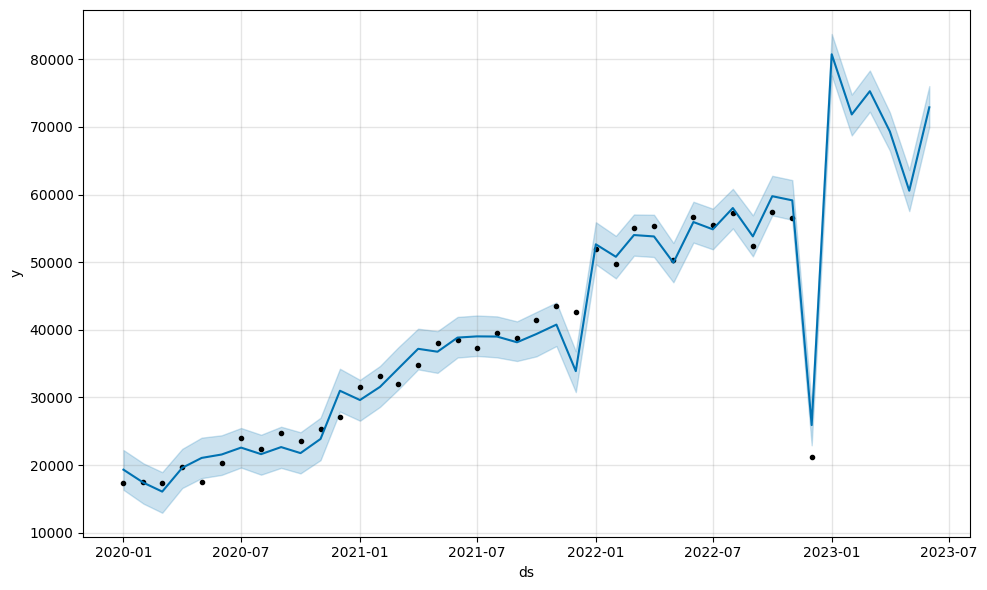

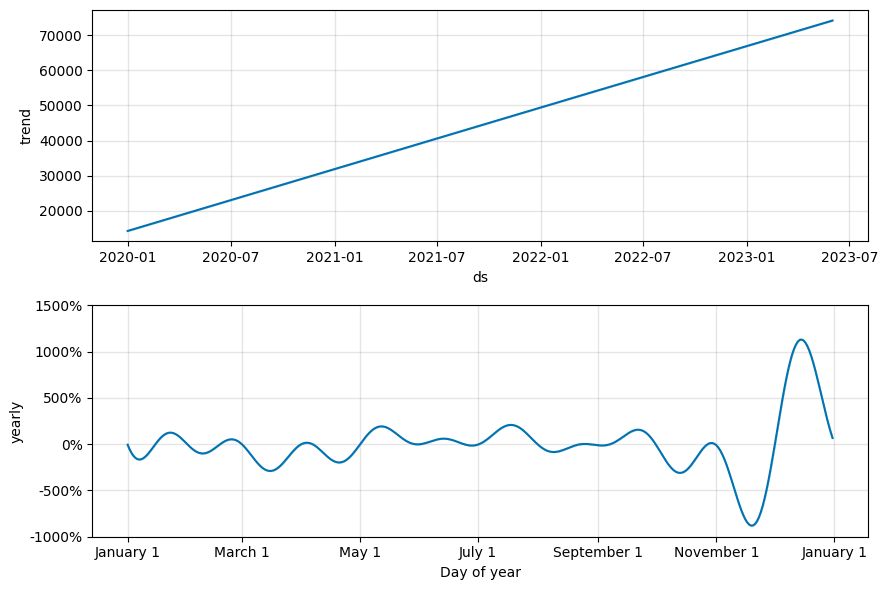

,ds,yhat,yhat_lower,yhat_upper
32,2022-09-01,53812.807642,50856.335670,56922.789306
33,2022-10-01,59756.534500,56919.774132,62769.751846
34,2022-11-01,59141.425672,56258.915898,62137.298758
35,2022-12-01,25907.868641,22921.552806,28741.241565
36,2023-01-01,80743.435670,77596.340181,83748.212616
37,2023-02-01,71844.656985,68739.004233,74780.722555
38,2023-03-01,75280.594720,72246.328487,78336.995513
39,2023-04-01,69319.074733,66484.551515,72130.386453
40,2023-05-01,60568.377318,57546.039139,63635.601171
41,2023-06-01,72897.262715,70000.483449,76040.095340


In [ ]:
ts_prophet = series.rename(columns={"month":"ds","MRR":"y"}).copy()
model_p = Prophet(growth="linear", seasonality_mode="multiplicative")
model_p.fit(ts_prophet)
future = model_p.make_future_dataframe(periods=6, freq="MS")
fcst = model_p.predict(future)
fig1 = model_p.plot(fcst)
plt.show()
fig2 = model_p.plot_components(fcst)
plt.show()
fcst.tail(10)[["ds","yhat","yhat_lower","yhat_upper"]]

#ARIMA Forecasting
Implementing ARIMA model for MRR forecasting

In [ ]:
ts_arima = series.set_index("month")["MRR"].asfreq("MS").fillna(0.0)
model_a = pm.auto_arima(ts_arima, seasonal=True, m=12, error_action="ignore", suppress_warnings=True, stepwise=True)
arima_fc = model_a.predict(n_periods=6)
arima_index = pd.date_range(ts_arima.index.max()+pd.offsets.MonthBegin(), periods=6, freq="MS")
arima_df = pd.DataFrame({"month": arima_index, "MRR_forecast_arima": arima_fc})
fig = go.Figure()
fig.add_trace(go.Scatter(x=series["month"], y=series["MRR"], mode="lines", name="MRR"))
fig.add_trace(go.Scatter(x=arima_df["month"], y=arima_df["MRR_forecast_arima"], mode="lines", name="ARIMA Forecast"))
fig.update_layout(title="ARIMA Forecast on MRR")
fig.show()
arima_df

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

,month,MRR_forecast_arima
2023-01-01,2023-01-01,67061.375
2023-02-01,2023-02-01,64825.375
2023-03-01,2023-03-01,70156.375
2023-04-01,2023-04-01,70485.375
2023-05-01,2023-05-01,65464.375
2023-06-01,2023-06-01,71767.375


#Kaplan-Meier Survival Analysis
Analyzing customer survival curves by subscription plan

In [ ]:
last_observed_month = status["month"].max()
cust_span = status.groupby("customer_id", as_index=False).agg(start=("cohort_month","min"), last=("month","max"))
cust_span["T"] = ((cust_span["last"].dt.year - cust_span["start"].dt.year)*12 + (cust_span["last"].dt.month - cust_span["start"].dt.month)).astype(int) + 1
churn_events = status.groupby("customer_id", as_index=False)["churn"].max()
sv = cust_span.merge(churn_events, on="customer_id", how="left").rename(columns={"churn":"E"})
sv = sv.merge(plan_map, on="customer_id", how="left")
sv = sv.merge(trial_map, on="customer_id", how="left")
sv = sv.merge(region_map, on="customer_id", how="left")
sv["ever_trial"] = sv["ever_trial"].fillna(False)
km = KaplanMeierFitter()
fig = go.Figure()
for grp, gdf in sv.groupby("plan"):
    km.fit(durations=gdf["T"], event_observed=gdf["E"])
    surv = km.survival_function_.reset_index().rename(columns={"index":"timeline","KM_estimate":"surv"})
    fig.add_trace(go.Scatter(x=surv["timeline"], y=surv["surv"], mode="lines", name=f"plan={grp}"))
fig.update_layout(title="Kaplan-Meier Survival by Plan", xaxis_title="Months", yaxis_title="Survival Probability")
fig.show()
sv.head()

,customer_id,start,last,T,E,plan,ever_trial,region
0,1,2020-09-01,2020-09-01,1,1,BASIC,False,Denmark
1,10,2022-09-01,2022-09-01,1,1,MAX,False,Finland
2,100,2022-08-01,2022-08-01,1,1,BASIC,False,Norway
3,1000,2022-05-01,2022-05-01,1,1,BASIC,False,Denmark
4,10000,2021-12-01,2022-06-01,7,1,PRO,False,Sweden


#Cox Proportional Hazards Model
Building a Cox model to identify factors affecting customer churn

In [ ]:
sv_cox = sv.copy()
sv_cox["ever_trial"] = sv_cox["ever_trial"].astype(int)
sv_cox["plan"] = sv_cox["plan"].astype("category")
sv_cox["region"] = sv_cox["region"].astype("category")

plan_dummies = pd.get_dummies(sv_cox["plan"], prefix="plan", drop_first=True)
region_dummies = pd.get_dummies(sv_cox["region"], prefix="region", drop_first=True)

sv_cox = pd.concat([sv_cox[["T","E","ever_trial"]], plan_dummies, region_dummies], axis=1)

# Keep T and E always, drop only other zero-variance columns
constant_cols = [c for c in sv_cox.columns if sv_cox[c].nunique() <= 1 and c not in ["T","E"]]
sv_cox = sv_cox.drop(columns=constant_cols)

cox = CoxPHFitter(penalizer=0.1)
cox.fit(sv_cox, duration_col="T", event_col="E", show_progress=False)
cox_summary = cox.summary
cox_summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
plan_MAX,0.003663,1.003670,0.025427,-0.046173,0.053499,0.954877,1.054956,0.0,0.144074,8.854421e-01,0.175530
plan_PRO,-0.187053,0.829400,0.020621,-0.227470,-0.146636,0.796546,0.863608,0.0,-9.070874,1.180660e-19,62.877040
region_Finland,0.010346,1.010399,0.028061,-0.044652,0.065343,0.956330,1.067526,0.0,0.368692,7.123572e-01,0.489327
region_Norway,0.022436,1.022690,0.027607,-0.031673,0.076546,0.968823,1.079552,0.0,0.812690,4.163959e-01,1.263972
region_Sweden,0.008399,1.008434,0.023638,-0.037931,0.054729,0.962779,1.056254,0.0,0.355310,7.223571e-01,0.469216


#Model Cross-Validation
Evaluating the Cox model using k-fold cross-validation

In [ ]:
scores = k_fold_cross_validation(CoxPHFitter(penalizer=0.001), sv_cox, duration_col="T", event_col="E", k=3, scoring_method="concordance_index")
pd.DataFrame({"fold": np.arange(1, len(scores)+1), "concordance": scores, "mean": np.mean(scores)})

,fold,concordance,mean
0,1,0.548884,0.545617
1,2,0.558610,0.545617
2,3,0.529356,0.545617


#Cohort Retention Analysis
Analyzing customer retention patterns across different cohorts

In [ ]:
ret = status.copy()
ret = ret[ret["in_lifecycle"]==True]
ret_pivot = ret.pivot_table(index="cohort_month", columns="months_since_cohort", values="customer_id", aggfunc=lambda x: x.nunique())
ret_norm = ret_pivot.div(ret_pivot[0], axis=0).fillna(0.0)
fig = px.imshow(ret_norm, aspect="auto", origin="lower", title="Cohort Retention Ratio", labels=dict(color="Retention"))
fig.show()
ret_norm.head()

months_since_cohort,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
cohort_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.0,0.983713,0.980456,0.977199,0.928339,0.902280,0.856678,0.804560,0.749186,0.697068,0.648208,0.612378,0.573290,0.517915,0.469055,0.446254,0.423453,0.400651,0.384365,0.364821,0.351792,0.345277,0.325733,0.283388,0.257329,0.244300,0.228013,0.205212,0.169381,0.156352,0.140065,0.123779,0.107492,0.068404,0.029316
2020-02-01,1.0,0.973422,0.966777,0.956811,0.920266,0.897010,0.863787,0.827243,0.770764,0.720930,0.667774,0.614618,0.551495,0.511628,0.478405,0.455150,0.431894,0.408638,0.382060,0.342193,0.315615,0.282392,0.262458,0.235880,0.212625,0.196013,0.166113,0.146179,0.119601,0.099668,0.083056,0.063123,0.039867,0.003322,0.000000
2020-03-01,1.0,0.962199,0.955326,0.941581,0.917526,0.862543,0.831615,0.800687,0.759450,0.711340,0.673540,0.642612,0.587629,0.529210,0.501718,0.467354,0.443299,0.408935,0.371134,0.347079,0.326460,0.292096,0.264605,0.240550,0.213058,0.192440,0.175258,0.154639,0.130584,0.096220,0.068729,0.048110,0.020619,0.000000,0.000000
2020-04-01,1.0,0.959866,0.953177,0.939799,0.896321,0.849498,0.816054,0.785953,0.762542,0.715719,0.685619,0.632107,0.595318,0.541806,0.498328,0.458194,0.428094,0.401338,0.381271,0.344482,0.311037,0.290970,0.250836,0.230769,0.200669,0.170569,0.153846,0.130435,0.100334,0.073579,0.033445,0.016722,0.000000,0.000000,0.000000
2020-05-01,1.0,0.945255,0.945255,0.930657,0.894161,0.846715,0.817518,0.773723,0.729927,0.678832,0.631387,0.587591,0.547445,0.503650,0.456204,0.419708,0.386861,0.364964,0.335766,0.302920,0.273723,0.244526,0.211679,0.193431,0.175182,0.156934,0.127737,0.098540,0.076642,0.062044,0.036496,0.000000,0.000000,0.000000,0.000000


#Cox Model Refinement
Refining the Cox model with improved preprocessing



In [ ]:
from lifelines.utils import k_fold_cross_validation

def preprocess_for_cox(df):
    df = df.copy()
    df["ever_trial"] = df["ever_trial"].astype(int)
    df["plan"] = df["plan"].astype("category")
    df["region"] = df["region"].astype("category")

    plan_dummies = pd.get_dummies(df["plan"], prefix="plan", drop_first=True)
    region_dummies = pd.get_dummies(df["region"], prefix="region", drop_first=True)

    df = pd.concat([df[["T","E","ever_trial"]], plan_dummies, region_dummies], axis=1)

    constant_cols = [c for c in df.columns if df[c].nunique() <= 1 and c not in ["T","E"]]
    df = df.drop(columns=constant_cols)

    return df

sv_cox_cv = preprocess_for_cox(sv)

cox_cv = CoxPHFitter(penalizer=0.5, l1_ratio=0.1)
scores = k_fold_cross_validation(cox_cv, sv_cox_cv, duration_col="T", event_col="E", k=3, scoring_method="concordance_index")
scores, np.mean(scores)

([0.5314215244694501, 0.5366539368207673, 0.5333174511067158],
 0.5337976374656445)

#Scenario Analysis
Simulating and visualizing different business scenarios

In [ ]:
km = KaplanMeierFitter()
km.fit(sv["T"], event_observed=sv["E"])
baseline_survival = km.survival_function_

def simulate_retention(price_multiplier=1.0, trial_boost=0.0):
    surv = baseline_survival.copy()
    surv["S"] = surv["KM_estimate"] * price_multiplier
    surv["S"] = surv["S"].apply(lambda x: min(1, max(0, x + trial_boost)))
    return surv.reset_index()

sim_base = simulate_retention()
sim_price_up = simulate_retention(price_multiplier=0.9)
sim_trial_up = simulate_retention(trial_boost=0.05)


def plot_scenarios(sim, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sim["timeline"], y=sim["S"], mode="lines", name=title))
    fig.update_layout(title=title, xaxis_title="Time", yaxis_title="Retention Probability")
    fig.show()

plot_scenarios(sim_base, "Baseline Forecast")
plot_scenarios(sim_price_up, "Price +10% (lower survival)")
plot_scenarios(sim_trial_up, "Trial Uplift +5% (higher survival)")


#Survival Shift Simulation
Modeling survival under retention improvement scenarios

In [ ]:
def survival_under_shift(sv_df, shift):
    svx = sv_df.copy()
    svx["ever_trial"] = svx["ever_trial"].astype(int)
    svx["T_mod"] = (svx["T"] * (1.0 + shift)).clip(lower=1).astype(int)
    svx["E_mod"] = svx["E"]
    km = KaplanMeierFitter()
    agg = []
    for grp, gdf in svx.groupby("plan"):
        km.fit(durations=gdf["T_mod"], event_observed=gdf["E_mod"])
        s = km.survival_function_.reset_index()
        s["plan"] = grp
        agg.append(s)
    return pd.concat(agg, ignore_index=True)
sv_shift = survival_under_shift(sv, 0.1)
fig = px.line(sv_shift, x=sv_shift.columns[0], y=sv_shift.columns[1], color="plan", title="Survival Under +10% Retention Shift")
fig.show()
sv_shift.head()

,timeline,KM_estimate,plan
0,0.0,1.000000,BASIC
1,1.0,0.508290,BASIC
2,4.0,0.476078,BASIC
3,5.0,0.444576,BASIC
4,6.0,0.409758,BASIC


#Profitability Comparison
Comparing profitability across different business scenarios

In [ ]:
def prepare_simulation(df, est_new_customers=1200, price_per_customer=10.0):
    d = df.copy()
    d = d.rename(columns={"timeline": "month"})
    d["active_customers"] = est_new_customers * d["KM_estimate"]
    d["MRR_blend"] = d["active_customers"] * price_per_customer
    return d

def profitability(sim_df, cac_per_customer=0.0, discount_rate_annual=0.1, est_new_customers=1200):
    d = prepare_simulation(sim_df, est_new_customers=est_new_customers)
    monthly_rate = (1.0 + discount_rate_annual) ** (1/12) - 1.0
    d = d.sort_values("month")
    d["t"] = np.arange(1, len(d)+1)
    d["discount_factor"] = 1.0 / ((1.0 + monthly_rate) ** d["t"])
    rev = d["MRR_blend"].sum()
    npv = (d["MRR_blend"] * d["discount_factor"]).sum()
    cac_total = cac_per_customer * est_new_customers
    return {
        "nominal_revenue": float(rev),
        "npv_revenue": float(npv),
        "cac_total": float(cac_total),
        "npv_net": float(npv - cac_total)
    }

profit_base  = profitability(sim_base,     cac_per_customer=15.0, discount_rate_annual=0.12, est_new_customers=1200)
profit_price = profitability(sim_price_up, cac_per_customer=15.0, discount_rate_annual=0.12, est_new_customers=1200)
profit_trial = profitability(sim_trial_up, cac_per_customer=15.0, discount_rate_annual=0.12, est_new_customers=1200)

pd.DataFrame([profit_base, profit_price, profit_trial], index=["baseline","price+10%","trial+5%"])


,nominal_revenue,npv_revenue,cac_total,npv_net
baseline,97294.23114,90124.30522,18000.0,72124.30522
price+10%,97294.23114,90124.30522,18000.0,72124.30522
trial+5%,97294.23114,90124.30522,18000.0,72124.30522


#Results Export
Saving analysis results and artifacts for future reference

In [ ]:
os.makedirs("artifacts", exist_ok=True)

series.to_csv("artifacts/mrr_series.csv", index=False)
fcst.to_csv("artifacts/prophet_forecast.csv", index=False)
arima_df.to_csv("artifacts/arima_forecast.csv", index=False)

sim_base.to_csv("artifacts/blend_baseline.csv", index=False)
sim_price_up.to_csv("artifacts/blend_price_up.csv", index=False)
sim_trial_up.to_csv("artifacts/blend_trial_up.csv", index=False)

sv.to_csv("artifacts/survival_table.csv", index=False)
cox_summary.to_csv("artifacts/cox_summary.csv")


#Churn Prediction Model
Building a logistic regression model to predict customer churn

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df = pd.read_csv("Customer_Subscription_And_Transaction_Details.csv")
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

cust_features = df.groupby("cust_id").agg(
    tenure=("transaction_date", lambda x: (x.max() - x.min()).days // 30),
    plan_price=("subscription_price", "mean"),
    last_date=("transaction_date", "max")
).reset_index()

cutoff_date = df["transaction_date"].max() - pd.Timedelta(days=90)
cust_features["churned"] = (cust_features["last_date"] < cutoff_date).astype(int)

X = cust_features[["tenure", "plan_price"]].values
y = cust_features["churned"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       345
           1       0.83      1.00      0.91      1729

    accuracy                           0.83      2074
   macro avg       0.42      0.50      0.45      2074
weighted avg       0.69      0.83      0.76      2074

ROC AUC: 0.6108381321195966


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#Statistical Analysis
Using statsmodels for detailed statistical analysis of churn factors

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(cust_features[["tenure", "plan_price"]])
y = cust_features["churned"]

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.424912
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                churned   No. Observations:                10366
Model:                          Logit   Df Residuals:                    10363
Method:                           MLE   Df Model:                            2
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:                 0.02226
Time:                        08:07:26   Log-Likelihood:                -4404.6
converged:                       True   LL-Null:                       -4504.9
Covariance Type:            nonrobust   LLR p-value:                 2.799e-44
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9879      0.104     28.822      0.000       2.785       3.191
tenure         0.0039      0.